# Training ADHunter on TREBL-seq data
GOAL: Transfer learn to predict $t_{1/2}$ from TREBL-seq using transfer learning from my Gcn4 model 

In [1]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import os
from Bio.Seq import Seq

pl.seed_everything(0)

Global seed set to 0


0

In [2]:
df = pd.read_csv("../data/EC_TREBLactivities_20250321_v2.csv")
df["AAseq"] = df["Tile"].apply(lambda seq: "".join(Seq(seq).translate()))
# print(sum(df[df["AAseq"].str.len() == 40]) / len(df))
df = df[df["AAseq"].str.len() == 40]
df = df.loc[df.loc[:, ['AAseq', 'Vmax']].drop_duplicates().index]
df_ad = df[df["Activity"]=="active"].copy()

seqs = df_ad["AAseq"].to_numpy()
# activity = df["Vmax"].to_numpy()
# y_bin = (df_ad["Activity"] == "active").values


t_half = df_ad["T1/2"].to_numpy().reshape(-1, 1)
t_scaler = preprocessing.StandardScaler().fit(t_half)
t_half_scaled = t_scaler.transform(t_half)
y_cont = t_half_scaled
# Split t1/2 into above/below median
t_half_median = np.median(t_half)
y_bin = t_half > t_half_median
# Add speed annotations to df_ad
df_ad["speed"] = "fast"
df_ad.loc[y_bin.flatten(), "speed"] = "slow"


# convert seqs to integer valued vectors
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])

# train, val, test, indices = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
# (X_train, y_bin_train, y_cont_train) = train
# (X_val, y_bin_val, y_cont_val) = val
# (X_test, y_bin_test, y_cont_test) = test
# test_idx, val_idx = indices

In [3]:
# X_non_ad = torch.stack(df.loc[df["Activity"]=="inactive", "AAseq"].apply(model.model.encode).tolist()).squeeze()
# # model.eval()
# # with torch.no_grad():
# # print(model(X_non_ad).detach())
# X_neg = X_non_ad.mean(dim=0).unsqueeze(0)
# model(X_neg)

In [4]:
# model(model.model.encode(torch.tensor(X)))

In [5]:
fn = "../data/OrthologTilingDFwActivities_20240930.csv"
df_gcn4 = pd.read_csv(fn)
df_gcn4["Activity"] = df_gcn4["Activity"].fillna(0.0)
# df_gcn4 = df_gcn4.loc[df_gcn4.Activity != 0.0]
# df_gcn4 = df_gcn4.iloc[:, 1:]
df_gcn4 = df_gcn4.loc[df_gcn4.loc[:, ['Seq', 'Activity']].drop_duplicates().index]
# df_gcn4 = df_gcn4.dropna(subset=df_gcn4.columns[:-1], axis=0)
df_gcn4.rename(columns={"Seq": "AAseq"}, inplace=True)

In [6]:
# Append sequences only in trebl data to gcn4 dataframe and assign "None" as species name
trebl_unique = pd.DataFrame(df_ad["AAseq"][~df_ad["AAseq"].isin(df_gcn4["AAseq"])])
print(trebl_unique.shape)

(25, 1)


In [7]:
df_gcn4 = pd.concat([df_gcn4, trebl_unique], ignore_index=True)

In [8]:
# print(df.shape, df_gcn4.shape)
df_m = pd.merge(df_ad, df_gcn4, on="AAseq", suffixes=["_trebl", "_gcn4"]).sort_values(by="SpeciesNames")
df_m["SpeciesNames"] = df_m["SpeciesNames"].fillna("None")
df_m

,Unnamed: 0_trebl,level_0,index,Tile,0,5,10,15,30,180,...,Activity_trebl,T1/2,AAseq,speed,Unnamed: 0_gcn4,SpeciesNames,NativeLocation,NormLocation,Activity_gcn4,Stdev_BYS4_BioReps
463,463,NaN,NaN,ATGCCAACTAATGATTTAAATTCTGCTATTTCTATGTTTGAAATGA...,6.194464,9.135603,10.559775,11.368124,15.096697,11.628647,...,active,10.530747,MPTNDLNSAISMFEMNVNTPGAGAAAAAAPCNPSVGAYHM,slow,87709.0,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,20.0,-115.0,54705.618558,85.565128
1802,1802,NaN,NaN,TCTACTGATTTGGATTCTGCTGTTGAGAACTTCTTTGGTTCTTCTT...,0.360111,4.120431,8.676081,11.721410,12.898664,13.449345,...,active,8.055872,STDLDSAVENFFGSSSDSTPLFEFEGLGKTTDPKTWSSLF,fast,87729.0,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,120.0,-15.0,262143.000000,NaN
1969,1969,NaN,NaN,TCTGATTCTACTCCATTGTTTGAATTTGAAGGTTTGGGTAAGACTA...,0.954741,4.561120,9.577172,14.694717,15.207149,17.645372,...,active,9.723771,SDSTPLFEFEGLGKTTDPKTWSSLFDDDIPVTLEDVSSVE,fast,87732.0,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,135.0,0.0,129540.750244,161829.257282
2015,2015,NaN,NaN,TCTGTTCCAATCTTCTCTGAATCTAAGAGATCTACTGATTTGGATT...,1.367910,3.876100,6.620588,10.923745,11.650322,10.364716,...,active,9.796916,SVPIFSESKRSTDLDSAVENFFGSSSDSTPLFEFEGLGKT,fast,87727.0,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,110.0,-25.0,150908.088872,NaN
276,276,NaN,NaN,ACTGATCCTAAGACTTGGTCTTCTTTGTTTGATGATGATATTCCAG...,0.597847,2.659881,4.457487,6.221736,8.724962,10.150257,...,active,12.597605,TDPKTWSSLFDDDIPVTLEDVSSVESITTAAGTESCFLPT,slow,87735.0,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,150.0,15.0,153637.922819,73069.339945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799,1799,NaN,NaN,TCTACTGATTCTACTCCAATGTTTGATTATGATAATTTGGAAGATA...,1.025557,4.170933,7.658006,10.881274,11.314568,15.254404,...,active,10.747649,STDSTPMFDYDNLEDNSKDWTSLFDNDIPVTTDDVSLADK,slow,NaN,None,NaN,NaN,NaN,NaN
1800,1800,NaN,NaN,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...,2.679085,4.674611,5.114578,6.129602,7.458950,10.324391,...,active,24.677893,STDSTPAAEAENAEDNSKEWTSLFDNDIPVTTDDVSLADK,slow,NaN,None,NaN,NaN,NaN,NaN
1801,1801,NaN,NaN,TCTACTGATTCTATGCCAATGACTGAATATGAGAATTTGGAAGATA...,1.887299,20.817146,23.177571,33.684915,20.583454,23.656139,...,active,4.199402,STDSMPMTEYENLEDNLKEWTHLFDNVIPNTTDDVSLADK,fast,NaN,None,NaN,NaN,NaN,NaN
1812,1812,NaN,NaN,TCTACTGCTCCACCAACTGATGTTTCTTTGGGTGATGAATTGCATT...,0.921482,3.854875,6.118787,8.659950,12.356368,12.586083,...,active,11.605048,STAPPTDVSLGDELHLDGEDVAMAHADALDDFDLDMLGDG,slow,NaN,None,NaN,NaN,NaN,NaN


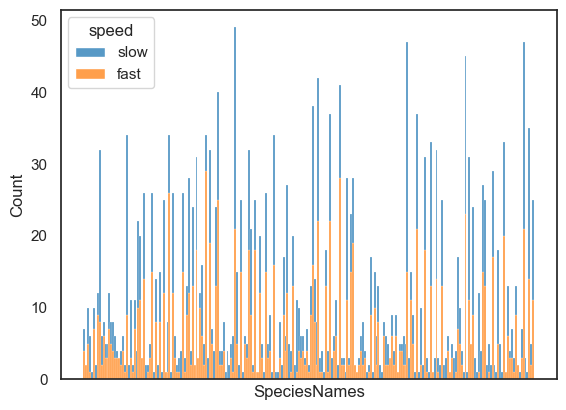

In [9]:
# sns.lineplot(df_m, x="NativeLocation", y="T1/2", hue="SpeciesNames")

# df_m.sort
sns.histplot(df_m, x="SpeciesNames", hue="speed", multiple="stack")
plt.xticks([])
plt.show()
# sns.scatterplot(pd.DataFrame(df_m.groupby(["SpeciesNames"])["T1/2"].std().dropna()).reset_index())
# sns.boxplot(df_m, y="T1/2", x="SpeciesNames")
# plt.show()

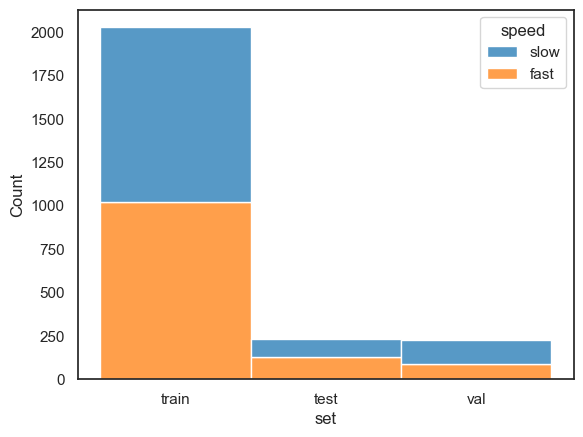

In [10]:
from sklearn.model_selection import GroupShuffleSplit

# groups = df_m["SpeciesNames"].values
# random_state = 42

def get_group_split(X, y, groups, random_state=0, as_tensor=True):
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=random_state)
    gss_val_test = GroupShuffleSplit(n_splits=1, train_size=.5, random_state=random_state)
    tr_idx, te_val_index = [], []
    te_idx, val_idx = [], []

    for i, (train_index, test_index) in enumerate(gss.split(X, y, groups=groups)):
        # Prepare the training and testing data
        X_train, X_test_val = X[train_index], X[test_index]
        y_train, y_test_val = y[train_index], y[test_index]
        # Keep track of indices
        tr_idx.append(train_index)
        te_val_index.append(test_index)

    te_val_index = np.array(te_val_index).flatten()

    groups_te_val = groups[te_val_index]
    for i, (test_index, val_index) in enumerate(gss_val_test.split(X_test_val, y_test_val, groups=groups_te_val)):
        X_test, X_val = X_test_val[test_index], X_test_val[val_index]
        y_test, y_val = y_test_val[test_index], y_test_val[val_index]
        te_idx.append(te_val_index[test_index])
        val_idx.append(te_val_index[val_index])


    tr_idx = np.array(tr_idx).flatten()
    te_idx = np.array(te_idx).flatten()
    val_idx = np.array(val_idx).flatten()
    if as_tensor:
        X_train = torch.tensor(X_train)
        # y_bin_train = torch.tensor(y_bin_train)
        y_train = torch.tensor(y_train)

        X_val = torch.tensor(X_val)
        # y_bin_val = torch.tensor(y_bin_val)
        y_val = torch.tensor(y_val)

        X_test = torch.tensor(X_test)
        # y_bin_test = torch.tensor(y_bin_test)
        y_test = torch.tensor(y_test)
    return (X_train, y_train), \
        (X_val, y_val), \
        (X_test, y_test), \
        (tr_idx, val_idx, te_idx)

train, val, test, indices = get_group_split(X, y_cont, df_m["SpeciesNames"].values)
(X_train, y_cont_train) = train
(X_val, y_cont_val) = val
(X_test, y_cont_test) = test
tr_idx, val_idx, te_index = indices
df_m.loc[df_m.iloc[tr_idx].index, ["set"]] = "train"
df_m.loc[df_m.iloc[te_index].index, ["set"]] = "test"
df_m.loc[df_m.iloc[val_idx].index, ["set"]] = "val"

sns.histplot(df_m, x="set", hue="speed", multiple="stack")
plt.show()

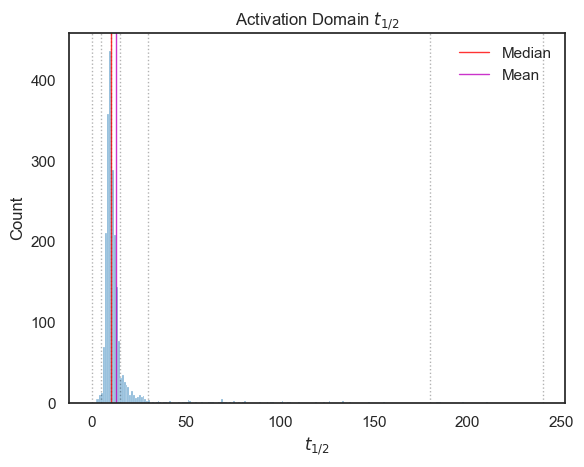

In [11]:
sns.histplot(t_half, discrete=True, legend=False)
for t in df.columns[4:11].astype(int):
    plt.axvline(t, linewidth=1, c='k', alpha=0.3, linestyle="dotted")
# plt.yscale("log")
plt.axvline(t_half_median, c='r', linewidth=1, alpha=0.8, label="Median")
plt.axvline(np.mean(t_half), c='m', linewidth=1, alpha=0.8, label="Mean")
plt.xlabel("$t_{1/2}$")
plt.title("Activation Domain $t_{1/2}$")
plt.legend(frameon=False, loc="upper right")
plt.show()

In [12]:
# train, val, test, indices = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
# (X_train, y_bin_train, y_cont_train) = train
# (X_val, y_bin_val, y_cont_val) = val
# (X_test, y_bin_test, y_cont_test) = test
# test_idx, val_idx = indices

In [13]:
# Code to split based on t1/2 and X alone with no stratification; 
# I don't think models trained with this sort of split are very consistent

# from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

# splitter = ShuffleSplit(n_splits=1,
#                         train_size=0.8,
#                         random_state=0)
# train_index, val_test_index = list(splitter.split(X, y_cont))[0]
# X_train = X[train_index]
# y_cont_train = y_cont[train_index]

# X_val_test = X[val_test_index]
# y_cont_val_test = y_cont[val_test_index]

# splitter = ShuffleSplit(n_splits=1,
#                         train_size=0.5,
#                         random_state=0)
# val_index, test_index = list(splitter.split(X_val_test, y_cont_val_test))[0]
# X_val = X_val_test[val_index]
# y_cont_val = y_cont_val_test[val_index]
# X_test = X_val_test[test_index]
# y_cont_test = y_cont_val_test[test_index]

# # Convert everything to tensors
# X_train = torch.tensor(X_train)
# y_cont_train = torch.tensor(y_cont_train)
# X_val = torch.tensor(X_val)
# y_cont_val = torch.tensor(y_cont_val)
# X_test = torch.tensor(X_test)
# y_cont_test = torch.tensor(y_cont_test)

In [14]:
# Create Training and Validation Datasets
bs = 128
train_ds = TensorDataset(X_train, y_cont_train.to(torch.float))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

val_ds = TensorDataset(X_val, y_cont_val.to(torch.float))
val_dl = DataLoader(val_ds, batch_size=bs)

In [15]:
# import pytorch_lightning as pl
# import torch
# import torch.nn as nn
# import torch.nn.functional as Fun
# from torchmetrics import MeanSquaredError, PearsonCorrCoef, SpearmanCorrCoef
# # from sklearn.preprocessing import OneHotEncoder
# from actpred.models import ResBlock

# class ActCNN(nn.Module):

#     def __init__(self,
#                  hidden,
#                  kernel_size,
#                  dilation,
#                  num_res_blocks=3,
#                  seq_len=40,
#                  one_hot=True,
#                  out_feats=1):
#         super(ActCNN, self).__init__()
#         self.one_hot_explicit = one_hot
#         if self.one_hot_explicit:
#             self.emb = nn.Linear(20, hidden, bias=False)
#         else:
#             self.emb = nn.Embedding(20, embedding_dim=hidden, dtype=torch.float32)
#         self.conv_init = nn.Conv1d(in_channels=hidden,
#                                    kernel_size=kernel_size,
#                                    out_channels=hidden,
#                                    padding="same")
#         self.res_blocks = nn.ModuleList([
#             ResBlock(hidden, kernel_size, dilation)
#             for _ in range(num_res_blocks)
#         ])
#         self.pool = nn.MaxPool1d(kernel_size=seq_len)
#         self.lin = nn.Linear(hidden, out_feats)

#     def forward(self, X):
#         if self.one_hot_explicit:
#             X = self.encode(X).float()
#         out = self.emb(X)
#         out = out.transpose(2, 1)
#         out = self.conv_init(out)
#         for res_block in self.res_blocks:
#             out = res_block(out)
#         out = self.pool(out).squeeze()
#         out = self.lin(out)
#         return out
    
#     def one_hot_custom(self, arr, num_classes:int):
#         """Custom one hot encoding to allow encoding invalid indices 
#         as all 0 vectors.

#         Args:
#             arr (torch.tensor): Array of token indices corresponding to desired one hot index. 
#                 Input value >= num_classes to encode all 0's.
#             num_classes (int): _description_

#         Returns:
#             torch.tensor: one hot encoded array
#         """        
#         valid_mask = (arr >=0) & (arr < num_classes)
#         if valid_mask.all():
#             out = Fun.one_hot(arr, num_classes=num_classes)
#         else:
#             classes = range(num_classes)
#             rows, cols = arr.shape
#             out = torch.zeros((rows, cols, num_classes))
#             for i in range(rows):
#                 for j in range(cols):
#                     if arr[i, j] in classes:
#                         out[i, j, arr[i, j]] = 1
#                     out[i, j] = torch.zeros(num_classes)
#         return out
    
#     def encode(self, seq):
#         seq_len, n_aas = 40, 20
#         if type(seq) == torch.Tensor:
#             if seq.shape[-1] == n_aas:
#                 # Do nothing if already proper shape for one hot encoded
#                 return seq.float()
#             elif seq.shape[-1] == seq_len:
#                 # One hot encode if seq is a list of integer tokens of AAs
#                 seq = self.one_hot_custom(seq, num_classes=n_aas)
#                 return seq.float()
#         elif type(seq) == str:
#             alphabet="ACDEFGHIKLMNPQRSTVWY"
#             aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
#             assert len(seq) == seq_len, f"Sequence must be seq_len AA!"
#             seq = self.one_hot_custom(torch.tensor([[aa_to_i[i] for i in seq]], dtype=torch.int64), num_classes=n_aas)
#             return seq.float()

# class ActCNNSystem(pl.LightningModule):

#     def __init__(self,
#                  hidden,
#                  kernel_size,
#                  dilation,
#                  num_res_blocks=3,
#                  seq_len=40,
#                  weight_decay=1e-2,
#                  one_hot=True,
#                  out_feats=1):
#         super(ActCNNSystem, self).__init__()
#         self.save_hyperparameters()
#         self.wd = weight_decay
#         self.model = ActCNN(hidden,
#                             kernel_size,
#                             dilation,
#                             seq_len=seq_len,
#                             num_res_blocks=num_res_blocks,
#                             one_hot=one_hot,
#                             out_feats=out_feats)
#         self.loss_fn = nn.MSELoss()

#         self.rmse = MeanSquaredError(squared=False)
#         self.pearsonr = PearsonCorrCoef()
#         self.spearmanr = SpearmanCorrCoef()
#         self.metrics = {
#             "rmse": self.rmse,
#             "pearsonr": self.pearsonr,
#             "spearmanr": self.spearmanr
#         }

#     def forward(self, x):
#         return self.model(x)

#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(),
#                                      lr=1e-3,
#                                      weight_decay=self.wd)
#         return optimizer

#     def training_step(self, batch, batch_idx):
#         X, y = batch
#         y_pred = self.model(X)
#         loss = self.loss_fn(y_pred, y)
#         return {
#             "loss": loss,
#             "y_target": y.view(-1),
#             "y_pred": y_pred.detach().view(-1),
#         }

#     def training_epoch_end(self, train_step_outputs):
#         y_preds = [d['y_pred'] for d in train_step_outputs]
#         y_targets = [d['y_target'] for d in train_step_outputs]
#         y_preds = torch.concat(y_preds)
#         y_targets = torch.concat(y_targets)

#         train_loss = self.metrics['rmse'](y_preds, y_targets)
#         for metric_name, metric in self.metrics.items():
#             metric_name = "train_" + metric_name
#             self.log(metric_name, metric(y_preds, y_targets))
#         return

#     def validation_step(self, batch, batch_idx):
#         X, y = batch
#         y_pred = self.model(X)
#         return (y_pred.view(-1), y.view(-1))

#     def validation_epoch_end(self, val_step_outputs):
#         y_preds, y_targets = zip(*val_step_outputs)
#         y_preds = torch.concat(y_preds)
#         y_targets = torch.concat(y_targets)

#         val_loss = self.metrics['rmse'](y_preds, y_targets)
#         self.log("val_loss", val_loss)
#         for metric_name, metric in self.metrics.items():
#             metric_name = "val_" + metric_name
#             print(metric_name, metric(y_preds, y_targets).item(), flush=True)
#             self.log(metric_name, metric(y_preds, y_targets))
#         return val_loss


In [16]:
# import copy

kernel_size = 5
dilation = 3 
hidden = 64

model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("../adhunter/adhunter_1he.pt"))
# model.eval()

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


<All keys matched successfully>

In [17]:
dirpath="../misc/models"
csv_logger = CSVLogger('../misc/logs')
checkpoint_callback = ModelCheckpoint(dirpath=dirpath, monitor="val_loss", filename="min_val_loss", save_last=True)
patience=10
early_stopping = EarlyStopping('val_loss', patience=patience)

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=100)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../misc/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonCorrCoef  | 0     
4 | spearmanr | SpearmanCorrCoef | 0     
-----------------------------------------------
96.8 K    Trainable params
0         Non-trainable params
96.8 K    Total params
0.387     Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 22.05it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 25.61it/s]val_rmse 2.0122649669647217
val_pearsonr -0.21937386691570282
val_spearmanr -0.4533355236053467
                                                                           

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 39.43it/s, loss=0.921, v_num=41]val_rmse 1.3567819595336914
val_pearsonr 0.2199273556470871
val_spearmanr 0.2993561923503876
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 81.75it/s, loss=0.655, v_num=41]val_rmse 1.2401684522628784
val_pearsonr 0.36091148853302
val_spearmanr 0.3639344871044159
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 87.84it/s, loss=0.649, v_num=41]val_rmse 1.2660102844238281
val_pearsonr 0.3732335865497589
val_spearmanr 0.4401516616344452
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 74.93it/s, loss=0.562, v_num=41]val_rmse 1.2740060091018677
val_pearsonr 0.2845062017440796
val_spearmanr 0.3543914556503296
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 89.68it/s, loss=0.45, v_num=41] val_rmse 1.388046145439148
val_pearsonr 0.21353952586650848
val_spearmanr 0.15519221127033234
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 88.17it/s, loss=0.313, v_num=41]val_rmse 1.3394373655319214
val_pearsonr 0.16714857518672943
val_spe

In [18]:
# Load the best model
ckpt_dict = torch.load(checkpoint_callback.best_model_path)
model.load_state_dict(ckpt_dict["state_dict"])


<All keys matched successfully>

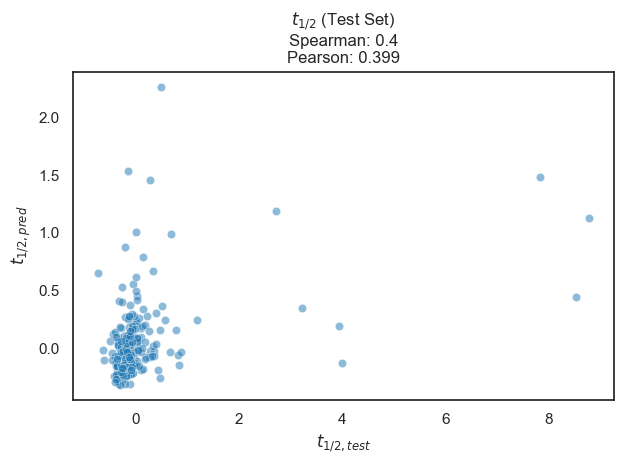

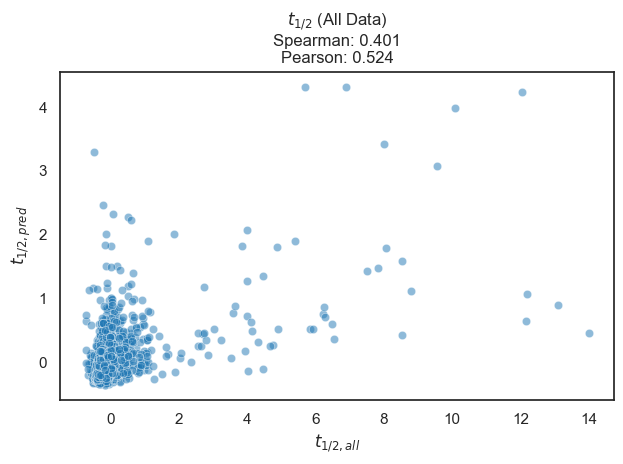

In [19]:
from scipy.stats import pearsonr, spearmanr
sns.set_style("white")
sns.set_context("notebook")

y_pred = model(X_test).detach().numpy().flatten()
y_te = y_cont_test.detach().numpy().flatten()


fig, ax = plt.subplots()
# sns.scatterplot(x=y_te[:, 0].flatten(), y=y_pred[:, 0].flatten(), alpha=.5, ax=axs[0])
# axs[0].set_xlabel("$V_{max, test}$")
# axs[0].set_ylabel("$V_{max, pred}$")
# spearman0 = spearmanr(y_te[:, 0].flatten(), y_pred[:, 0].flatten()).statistic.round(3)
# pearson0 = pearsonr(y_te[:, 0].flatten(), y_pred[:, 0].flatten()).statistic.round(3)

# axs[0].set_title("$V_{max}$\n" + f"Spearman: {spearman0}\nPearson: {pearson0}")

sns.scatterplot(x=y_te, y=y_pred, alpha=.5, ax=ax)
ax.set_xlabel("$t_{1/2, test}$")
ax.set_ylabel("$t_{1/2, pred}$")
spearman1 = spearmanr(y_te, y_pred).statistic.round(3)
pearson1 = pearsonr(y_te, y_pred).statistic.round(3)
ax.set_title("$t_{1/2}$ (Test Set)\n" + f"Spearman: {spearman1}\nPearson: {pearson1}")

fig.tight_layout()
plt.show()

y_all_pred = model(torch.tensor(X)).detach().numpy().flatten()
y_all = y_cont.flatten()
fig, ax = plt.subplots()
sns.scatterplot(x=y_all, y=y_all_pred, alpha=.5, ax=ax)
ax.set_xlabel("$t_{1/2, all}$")
ax.set_ylabel("$t_{1/2, pred}$")
spearman1 = spearmanr(y_all, y_all_pred).statistic.round(3)
pearson1 = pearsonr(y_all, y_all_pred).statistic.round(3)
ax.set_title("$t_{1/2}$ (All Data)\n" + f"Spearman: {spearman1}\nPearson: {pearson1}")

fig.tight_layout()
plt.show()

In [20]:
# X[:, y_bin]
# print(sum(y_bin))
X_slow = model.model.encode(torch.tensor(X[y_bin.flatten()]))
X_fast = model.model.encode(torch.tensor(X[~y_bin.flatten()]))
X_slow_avg = X_slow.mean(dim=0).unsqueeze(0)
X_fast_avg = X_fast.mean(dim=0).unsqueeze(0)
# X_fast_avg

In [21]:
from captum.attr import LayerDeepLift

dl = LayerDeepLift(model, model.model.emb, multiply_by_inputs=True)
attr_slow = dl.attribute(X_slow, X_fast_avg, attribute_to_layer_input=True)
attr_fast = dl.attribute(X_fast, X_slow_avg, attribute_to_layer_input=True)

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: >

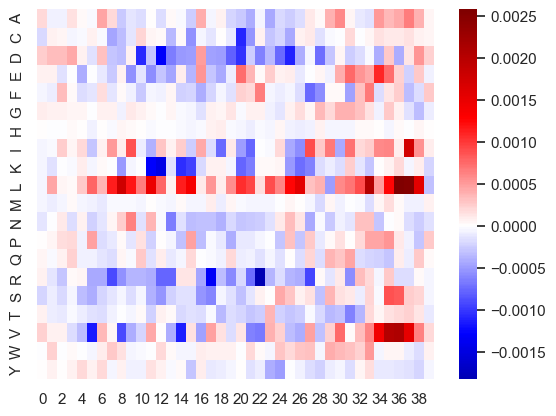

In [22]:
a_slo = pd.DataFrame(attr_slow.mean(dim=0).detach().numpy()).T
a_slo.index = list(alphabet)
sns.heatmap(a_slo, center=0, cmap="seismic")

In [23]:
df_ = df_ad.copy()
for i in alphabet:
    df_[i] = df_["AAseq"].str.count(i)
# df_[list(alphabet)].corr(df["T1/2"])
df_[["T1/2"] + list(alphabet)].corr()["T1/2"]
df_[["Vmax"] + list(alphabet)].corr()["Vmax"]

Vmax    1.000000
A       0.005038
C      -0.001318
D       0.050086
E      -0.007166
F       0.046077
G      -0.006456
H      -0.032676
I       0.006096
K      -0.008695
L       0.026960
M       0.014303
N       0.002609
P      -0.033187
Q       0.006486
R      -0.008001
S      -0.022017
T      -0.025185
V       0.007821
W       0.006879
Y      -0.037875
Name: Vmax, dtype: float64